In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.special import gammaln
from scipy.integrate import quad
from scipy.special import binom as sp_binom
# import quadpy

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, HBox, VBox, Output, FloatSlider
# from IPython.display import display

import os, sys
sys.path.append( os.path.dirname( os.path.abspath('') ) )

from inference.BayesModel import *
from inference.utils.utils import adaptive_integration, p_nu, f
from empirical.readData import *

%matplotlib ipympl

In [2]:
def adaptive_integration(f, x_lower, x_upper, args, eps_pow=-8, eps_thr=-4):
    while True:
        if eps_pow == eps_thr:
            # print('tolerance too high - breaking!')
            return None

        try:
            res, err = quad(
                f,
                x_lower,
                x_upper,
                args=args,
                epsabs=10**eps_pow,
                epsrel=10**eps_pow,
                points=np.logspace(-3, 0, 4),
            )

            break
        except:
            # print(f'error in integration with tolerance 10^{eps_pow}')
            eps_pow += 1
    return res

## Plot $p(N_{AP})$

1. from $p(\nu)$, discretized at integer spike times
       probability to observe neuron with at rate $\nu$ / with spike number $N_{AP} T$ is given by $\frac{p(\nu)}{T}$

In [3]:
ref_values = {"distr": [{"gamma": 1.5, "delta": 4.5, "nu_max": 25.0}], "T": 10, "N": 50}
mP = ModelParams(mode="artificial", parameter=ref_values)
BM, results, sampler = run_sampling(mP)

input parameters: self.params['distr'][m][key]=1.5, self.params['distr'][m][key]=4.5, self.params['distr'][m][key]=25.0, 
inferred parameters: options['rateWnt']=[0.9227737671099525], options['tau_I']=[0.004052847345693511], options['alpha_0']=[array([[0.03273402]])]


DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=True, nbootstraps=20, ndraw=512..65536


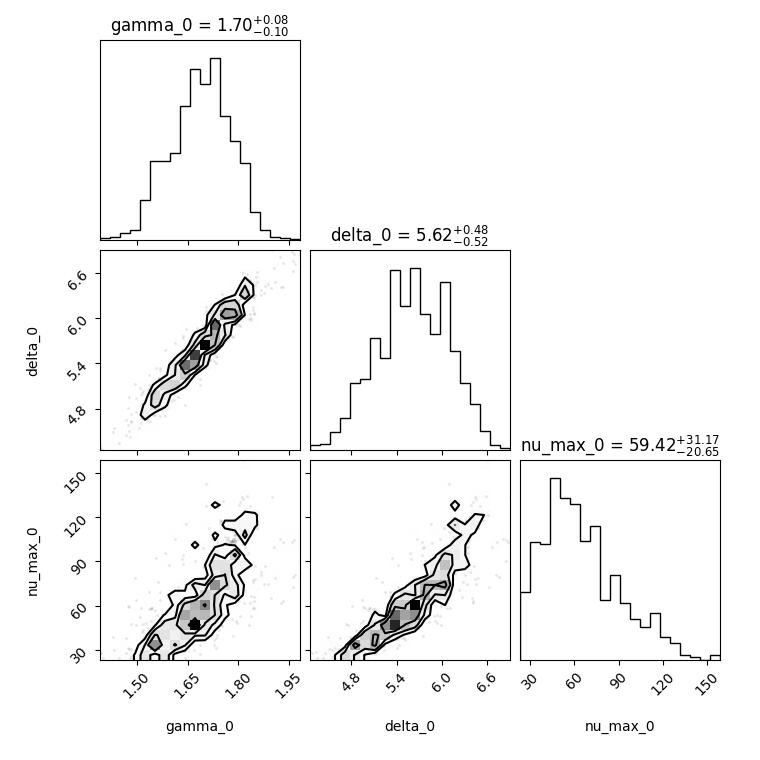

In [4]:
sampler.plot_corner()

In [6]:
results["posterior"]["mean"]

[1.690225298498604, 5.6168985102378945, 64.63679721034086]

[1.690225298498604, 5.6168985102378945, 64.63679721034086]


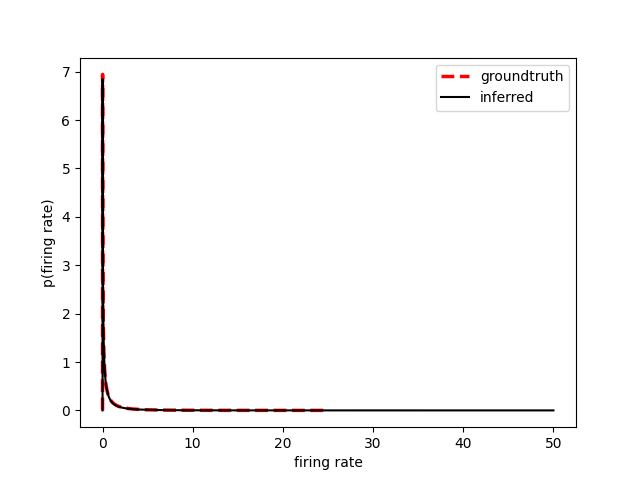

In [10]:
print(results["posterior"]["mean"])

nu_array = np.linspace(0, 50, 10001)
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(
    nu_array,
    p_nu(nu_array, ref_values),
    "r--",
    linewidth=2.5,
    label="groundtruth",
)
params = {"distr": [{}]}
for i, key in enumerate(["gamma", "delta", "nu_max"]):
    params["distr"][0][key] = results["posterior"]["mean"][i]
ax.plot(nu_array, p_nu(nu_array, params), "k-", label="inferred")

ax.legend()
plt.setp(ax, xlabel="firing rate", ylabel="p(firing rate)")
plt.show(block=False)

interactive(children=(IntSlider(value=60, description='T', max=1000, min=1), FloatSlider(value=1.0, descriptio…

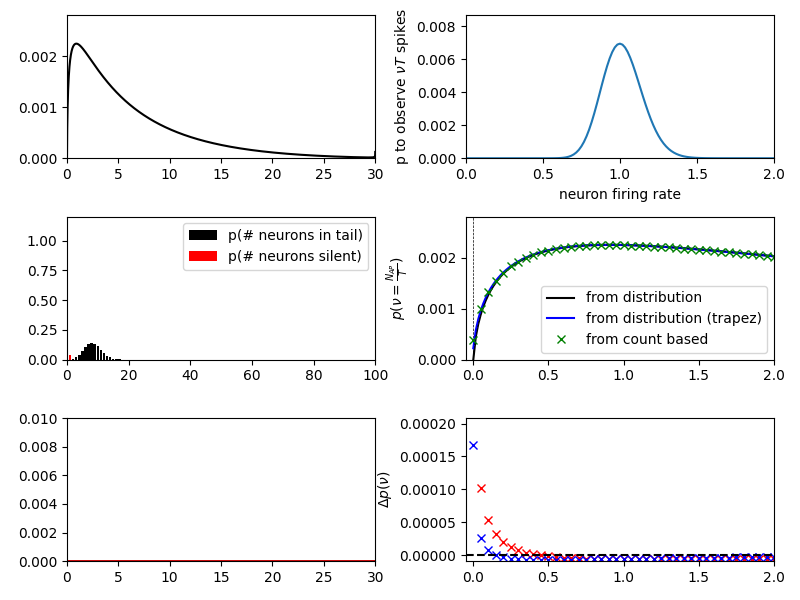

In [14]:
import warnings

warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

fig = plt.figure(figsize=(8, 6))

ax_full = fig.add_subplot(321)
ax_k_distr = fig.add_subplot(323)

ax_single = fig.add_subplot(322)
ax_p_N_AP = fig.add_subplot(324)
ax_p_N_AP_error = fig.add_subplot(326)
# fig,ax = plt.subplots(1,2,figsize=(12,4))
# ax[0][0].axvline(1.,linestyle='--',color='k')

# nNeurons = 100
(h_p_full,) = ax_full.plot(0, 0, "k-", label="from distribution")
(h_ax_single,) = ax_single.plot(0, 0)  # ,label=f'$T={T}$')
# ax_full.set_xscale('log')
# h_k_rects_tail = ax_k_distr.bar(range(nNeurons),np.zeros(nNeurons),facecolor='k',label='p(# neurons in tail)')
# h_k_rects_silent = ax_k_distr.bar(range(nNeurons),np.zeros(nNeurons),facecolor='r',label='p(# neurons silent)')
ax_k_distr.legend()


plt.setp(ax_single, xlabel="neuron firing rate", ylabel="p to observe $\\nu T$ spikes")

h_rateMarker = ax_p_N_AP.axvline(0.0, linestyle="--", color="k", linewidth=0.5)

###
steps = 50

(h_p_N_AP_cont,) = ax_p_N_AP.plot(0, 0, "k-", label="from distribution")
(h_p_N_AP_cont_trapez,) = ax_p_N_AP.plot(0, 0, "b-", label="from distribution (trapez)")
(h_p_N_AP_full,) = ax_p_N_AP.plot(0, 0, "k--", linewidth=0.5)
(h_p_N_AP,) = ax_p_N_AP.plot(0, 0, "xg", label="from count based")
plt.setp(
    ax_p_N_AP, xlim=[-0.05, 2], ylim=[0, 1.05], ylabel="$p(\\nu = \\frac{N_{AP}}{T})$"
)
ax_p_N_AP.legend()

(h_p_N_AP_error,) = ax_p_N_AP_error.plot(0, 0, "xr")
(h_p_N_AP_error_trapez,) = ax_p_N_AP_error.plot(0, 0, "xb")
ax_p_N_AP_error.axhline(0, linestyle="--", color="k")
ax_p_N_AP_error.set_xlim([-0.05, 2])
plt.setp(ax_p_N_AP_error, ylabel="$\\Delta p(\\nu)$")


ax_p_extreme = fig.add_subplot(325)
(h_p_extreme,) = ax_p_extreme.plot(0, 0, "k-")
(h_p_extreme_shift,) = ax_p_extreme.plot(0, 0, "r-")


gamma_slider = FloatSlider(value=1.5, min=0.0, max=5.0)
delta_slider = FloatSlider(value=4.0, min=1.0, max=10.0)
nu_max_slider = FloatSlider(value=25.0, min=10.0, max=100.0)

plt.tight_layout()
# param_control = VBox([gamma_slider,delta_slider,nu_max_slider])


@interact(
    T=(1, 1000),
    rateWnt=(0.0, 4.0),
    gamma=(0.0, 4.0),
    delta=(1.0, 10.0),
    nu_max=(15.0, 100.0),
    p=(0.0, 1.0),
    gamma_2=(0.0, 4.0),
    delta_2=(1.0, 10.0),
    nNeurons=(1, 1000),
)
def update_p_N_AP(
    T=60,
    rateWnt=1.0,
    gamma=1.8,
    delta=3.5,
    nu_max=30.0,
    p=0.5,
    gamma_2=1.2,
    delta_2=6.1,
    nNeurons=100,
    center=False,
    correct=False,
    two_pop=False,
):

    ## reset axes
    ax_k_distr.clear()

    ## set parameters into dictionary as required by the functions
    if two_pop:
        # delta_dark = gamma_dark/gamma * delta
        # gamma_dark = gamma
        params = (
            {
                "p": 0.5,
                "distr": [
                    {"gamma": gamma, "delta": delta, "nu_max": nu_max},
                    {"gamma": gamma_2, "delta": delta_2, "nu_max": nu_max},
                ],
            },
        )
    else:
        params = {"distr": [{"gamma": gamma, "delta": delta, "nu_max": nu_max}]}

    ## initialize arrays along x-axis (scale changes with T and nu_max)
    N_max = int(np.ceil(nu_max * T))
    nu_array = np.linspace(0, N_max / T, N_max + 1)
    nu_full = np.linspace(0, nu_max, 10001)

    offset = np.diff(nu_array)[0] / 2.0 if center else 0.0

    # p_full_sum = p_full[1:-1].sum()

    """ 1. PLOT FULL DISTRIBUTION """
    p_full = p_nu(nu_full, params) / T
    h_p_full.set_data(nu_full, p_full)
    plt.setp(ax_full, xlim=[0, nu_max], ylim=[0, 1.25 * np.nanmax(p_full)])
    # plt.setp(ax_full,xlim=[10**(-4),2*10**1],ylim=[0,1.25*np.nanmax(p_full)])

    """ 2. PLOT DISTRIBUTION OF NEURONS IN TAIL """
    k = np.arange(0, nNeurons)
    binom = sp_binom(nNeurons, k)

    tail_cutoff = nu_max / 2.0
    p_spike_count_in_empirical_range = adaptive_integration(
        p_nu, 0, tail_cutoff, args=(params)
    )
    p_spike_in_tail = 1 - p_spike_count_in_empirical_range

    logp_tail = (
        np.log(binom)
        + k * np.log(p_spike_in_tail)
        + (nNeurons - k) * np.log(1 - p_spike_in_tail)
    )
    p_tail = np.exp(logp_tail)

    ax_k_distr.bar(range(nNeurons), p_tail, facecolor="k", label="p(# neurons in tail)")

    """ 3. PLOT DISTRIBUTION TO OBSERVE RATEWNT*T SPIKES """
    ## update plot showing probability to observe N_AP spikes
    y_vals = f(nu_array, p=params, N_AP=np.array([rateWnt * T]), T=T)
    yy = y_vals[np.isfinite(y_vals)]

    h_ax_single.set_data(nu_array, y_vals)
    plt.setp(ax_single, xlim=[0, 2], ylim=[0, 1.25 * np.nanmax(yy)])

    # h_rateMarker.set_xdata(rateWnt)

    ## calculate the probability to observe N_AP spikes in any neuron
    N_max_steps = np.ceil(2 * T / steps) * steps
    rateWnt_array = np.linspace(0, N_max_steps / T, steps + 1)
    p_N_AP = np.zeros(steps + 1)
    for r, rateWnt in enumerate(rateWnt_array):

        p_N_AP[r] = adaptive_integration(
            f, 0, params["distr"][0]["nu_max"], args=(params, rateWnt * T, T)
        )

    """ 4. PLOT DISTRIBUTION TO OBSERVE n SILENT NEURONS """
    logp_silent = (
        np.log(binom) + k * np.log(p_N_AP[0]) + (nNeurons - k) * np.log(1 - p_N_AP[0])
    )
    p_silent = np.exp(logp_silent)
    ax_k_distr.bar(
        range(nNeurons), p_silent, facecolor="r", label="p(# neurons silent)"
    )

    plt.setp(
        ax_k_distr,
        xlim=[0, nNeurons],
        ylim=[0, np.nanmax([p_silent.max(), p_tail.max()]) * 1.25],
    )
    ax_k_distr.legend()

    # logp_lowactive = np.log(binom) + k*np.log(p_N_AP[1]) + (nNeurons-k)*np.log(1-p_N_AP[1])
    # p_lowactive = np.exp(logp_lowactive)
    # ax_k_distr.bar(range(nNeurons),p_lowactive,facecolor='g',label='p(# neurons lowactive)')

    """ 5. PLOT DISTRIBUTION CALCULATED FROM p_nu VS COUNT BASED """
    ## continuous
    # p_N_AP_cont = p_nu_single(nu_array + offset,**params) / T

    # p_N_AP_cont = p_nu(nu_array + offset,params,two_pop=True) / T
    p_N_AP_cont_trapez = (p_nu(nu_array[:-1], params) + p_nu(nu_array[1:], params)) / (
        2 * T
    )

    N_AP_array = np.linspace(0, N_max, N_max + 1)

    p_N_AP_cont = get_p_nu(
        (N_AP_array + offset) / T,
        params,
        T,
        correct_N=5 if correct else 0,
        correct_threshold=0.01,
    )

    p_N_AP_cont_points = p_nu(rateWnt_array + offset, params) / T
    p_N_AP_cont_points_trapez = (
        p_nu(rateWnt_array, params) + p_nu(rateWnt_array + 1.0 / T, params)
    ) / (2 * T)

    # print(p_N_AP_cont[-40:])
    # print(p_N_AP_cont[1:-1].sum())

    # if correct:
    # 	p_N_AP_cont[0] = 1 - p_N_AP_cont[1:-1].sum()
    # 	p_N_AP_cont_points[0] = 1 - p_N_AP_cont[1:-1].sum()

    yy = p_N_AP_cont[np.isfinite(p_N_AP_cont)]
    plt.setp(ax_p_N_AP, ylim=[0, 1.25 * np.nanmax(p_N_AP)])

    h_p_N_AP.set_data(rateWnt_array, p_N_AP)
    h_p_N_AP_cont.set_data(nu_array, p_N_AP_cont)
    h_p_N_AP_cont_trapez.set_data(nu_array[:-1], p_N_AP_cont_trapez)
    # fig.canvas.draw_idle()
    # return
    h_p_N_AP_full.set_data(nu_full, p_full)

    ### calculate error
    # p_N_AP_cont = p_nu_single(rateWnt_array + offset,**params) / T

    p_N_AP_error = p_N_AP - p_N_AP_cont_points
    p_N_AP_error_trapez = p_N_AP - p_N_AP_cont_points_trapez
    h_p_N_AP_error.set_data(rateWnt_array, p_N_AP_error)
    h_p_N_AP_error_trapez.set_data(rateWnt_array, p_N_AP_error_trapez)
    plt.setp(
        ax_p_N_AP_error,
        ylim=[p_N_AP_error_trapez.min() * 1.25, p_N_AP_error_trapez.max() * 1.25],
    )

    ## calculate the CDF and thus maximum value distribution
    if not correct:
        p_N_AP_cont = (
            get_p_nu(
                (N_AP_array + 0.5) / T, params, T, correct_N=5, correct_threshold=0.01
            )
            / T
        )

    p_N_AP_cum = np.cumsum(p_N_AP_cont)
    p_N_AP_cum = np.pad(
        p_N_AP_cum**nNeurons, (1, 0), mode="constant", constant_values=0
    )

    p_extreme = np.diff(p_N_AP_cum)
    p_extreme_edit = p_extreme * (1 - 1.0 / (nu_max - nu_array + 1) ** 2)
    # p_extreme *= nu_max*T/p_extreme.sum()

    h_p_extreme.set_data(nu_array, p_extreme)
    h_p_extreme_shift.set_data(nu_array, p_extreme_edit)

    # plt.setp(ax_p_extreme,xlim=[0,nu_max],ylim=[0,1.25*np.max(p_extreme[np.isfinite(p_extreme)])])
    plt.setp(ax_p_extreme, xlim=[0, nu_max], ylim=[0, 0.01])
    # print(f'{p_extreme.sum()=}')

    fig.canvas.draw_idle()

interactive(children=(FloatSlider(value=1.9, description='gamma', max=4.0), FloatSlider(value=3.5, description…

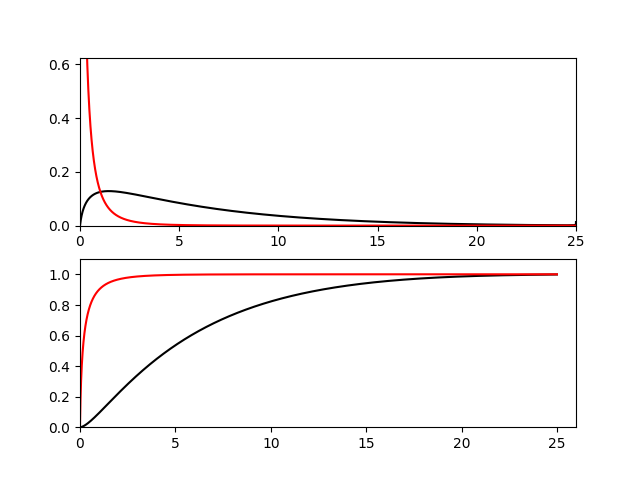

In [12]:
fig = plt.figure()


### plot two-mode distribution with sliders for gamma, delta, nu_max, and gamma_dark
ax_nu = fig.add_subplot(211)
ax_nu_cum = fig.add_subplot(212)

(h_p_nu,) = ax_nu.plot(0, 0, "k")
(h_p_nu_dark,) = ax_nu.plot(0, 0, "r")

(h_p_nu_cum,) = ax_nu_cum.plot(0, 0, "k")
(h_p_nu_dark_cum,) = ax_nu_cum.plot(0, 0, "r")


@interact(
    gamma=(0.0, 4.0), delta=(1.0, 10.0), nu_max=(15.0, 100.0), delta_dark=(0.0, 10.0)
)
def update_plot(gamma=1.9, delta=3.5, nu_max=25.0, delta_dark=6.1):

    steps = 10001
    nu = np.linspace(0, nu_max, steps)

    offset = nu_max / steps / 2.0
    nu += offset
    p_nu = p_nu_single(nu, gamma, delta, nu_max)
    h_p_nu.set_data(nu, p_nu)

    gamma_dark = gamma
    # delta_dark = gamma_dark/gamma * delta

    p_nu_dark = p_nu_single(nu, gamma_dark, delta_dark, nu_max)
    h_p_nu_dark.set_data(nu, p_nu_dark)

    print(f"dark parameters: {gamma_dark=}, {delta_dark=}, {nu_max=}")

    # p_nu_max = p_nu[np.isfinite(p_nu)].max()
    p_nu_dark_max = p_nu_dark[np.isfinite(p_nu_dark)].max()
    # print(f'{p_nu_max=}, {p_nu_dark_max=}')
    # max_val = np.nanmax([p_nu[np.isfinite(p_nu)],p_nu_dark[np.isfinite(p_nu_dark)]])
    # print(max_val)

    plt.setp(ax_nu, xlim=[0, nu_max], ylim=[0, 1.25 * np.min([0.5, p_nu_dark_max])])

    h_p_nu_cum.set_data(nu, np.nancumsum(p_nu) / steps * nu_max)
    h_p_nu_dark_cum.set_data(nu, np.nancumsum(p_nu_dark) / steps * nu_max)

    plt.setp(ax_nu_cum, xlim=[0, nu_max + 1], ylim=[0, 1.1])

    fig.canvas.draw_idle()